## Thesis, Sim Utility Evaluation Runs in Subway Environment

In [39]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

def getDataSetSize(path, filename, first_test, last_test):
    for test_number in range(first_test, last_test):
        data = np.array(np.genfromtxt(path + "/" + filename + str(test_number) + "_map.csv", delimiter=",", skip_header=1))
        if (test_number == first_test):
            data_set_size = data.shape[0]
        else:
            data_set_size = np.min((data_set_size, data.shape[0]))
    return data_set_size

class Test:
    def __init__(self, filename, path):
        file_info = filename.split('_')
        self._id = int(file_info[2][-1])
        self._utility = file_info[3]
        self._utility_param = float(file_info[4])
        self._gain = file_info[5]
        data = np.array(np.genfromtxt(path + filename, delimiter=",", skip_header=2))
        self._t = data[:,0]/60.0
        self._voxel_size = np.genfromtxt(path + filename, skip_footer=len(self._t)+1)
        self._map_data = data[:,1]

class TestGroup:
    def __init__(self, test0):
        self.label=test0._utility + " " + str(test0._utility_param)
        self.tests = [test0]

def checkIfTestMatchesGroup(test, group):
    if (test._utility == group.tests[0]._utility and test._utility_param == group.tests[0]._utility_param and test._gain == group.tests[0]._gain):
        return True
    else:
        return False

def groupTests(tests):
    test_groups = []
    for test in tests:
        test_added = False
        for group in test_groups:
            if checkIfTestMatchesGroup(test, group):
                group.tests.append(test)
                test_added = True
                break
        if (test_added == False):
            test_groups.append(TestGroup(test))
    return test_groups

def averageGroup(group):
    min_data_length = 0
    for test in group.tests:
        if (min_data_length == 0):
            min_data_length = len(test._t)
        min_data_length = min(len(test._t), min_data_length)
    t = group.tests[0]._t[:min_data_length]
    map_datas = []
    for test in group.tests:
        if (len(map_datas) == 0):
            map_datas.append(test._map_data[:min_data_length])
        else:
            map_datas = np.vstack((map_datas, test._map_data[:min_data_length]))
    return t, np.mean(map_datas, axis=0), np.std(map_datas, axis=0), map_datas

def getMaxMapVoxelCount(tests):
    max_voxels = 0.0
    for test in tests:
        max_voxels = max(max_voxels, np.max(test._map_data))
    return max_voxels

def getDataAtTime(t, data, t_target):
    for i in range(len(t)):
        if (t[i] >= t_target):
            return data[i], i
    return data[-1], -1

def getTimeAtExplorationRatioForGroup(group, voxel_target):
    min_data_length = 0
    for test in group.tests:
        if (min_data_length == 0):
            min_data_length = len(test._t)
        min_data_length = min(len(test._t), min_data_length)
    t = group.tests[0]._t[:min_data_length]
    t_at_target = []
    for test in group.tests:
        voxels = test._map_data[:min_data_length]
        for i in range(len(voxels)):
            if (voxels[i] >= voxel_target):
                t_at_target.append(t[i])
                break
    return np.average(t_at_target), np.std(t_at_target), t_at_target

efficiency 1.0
28.9 +/- 7.4 %
exponential 0.01
12.8 +/- 1.5 %
exponential 0.1
17.3 +/- 2.1 %
exponential 0.5
21.5 +/- 3.1 %
exponential 1.0
23.8 +/- 7.1 %
exponential 2.0
24.3 +/- 6.2 %
exponential 10.0
25.1 +/- 3.8 %
linear 10.0
12.1 +/- 2.3 %
linear 50.0
13.0 +/- 2.5 %
linear 100.0
18.1 +/- 2.2 %
linear 200.0
19.9 +/- 4.7 %
linear 500.0
19.8 +/- 5.2 %
linear 1000.0
23.9 +/- 5.1 %


(0.0, 100.0)

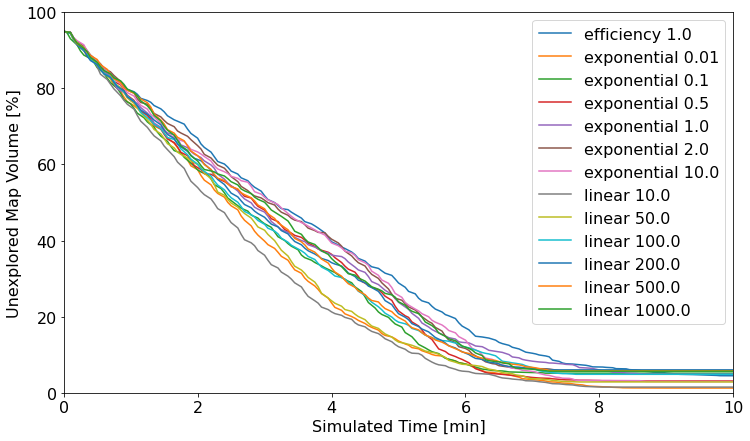

In [40]:
voxel_size = 0.2
path = "/home/andrew/tests/data/subway/"
sub_string = "unseen_map.csv"
tests = []
for filename in os.listdir(path):
    if sub_string in filename:
        file_info = filename.split('_')
        tests.append(Test(filename, path))

fig, ax = plt.subplots(figsize=[12.0, 7.0])
ax.tick_params(axis='both', which='major', labelsize='16')
plt.xlabel("Simulated Time [min]", fontsize='16')
plt.ylabel("Unexplored Map Volume [%]", fontsize='16')
# plt.title("IFVE Utility Function Comparison")
test_groups = groupTests(tests)
group_averages = []
full_map_voxels = getMaxMapVoxelCount(tests)
test_groups.sort(key=lambda x: (x.tests[0]._utility, x.tests[0]._utility_param))
for group in test_groups:
    t, _, _, raw_voxel_data = averageGroup(group)
    t = t - t[0]
    raw_volume_data = (1.0 - (raw_voxel_data/full_map_voxels))*100.0
    mean_volume = np.mean(raw_volume_data, axis=0)
    std_dev_volume = np.std(raw_volume_data, axis=0)
    volume_at_5min, _ = getDataAtTime(t, mean_volume, 5.0)
    volume_std_dev_at_5min, _ = getDataAtTime(t, std_dev_volume, 5.0)
    t_at_80percent_avg, t_at_80percent_std, t_at_80_percent = getTimeAtExplorationRatioForGroup(group, 0.8*full_map_voxels)
    plt.plot(t, mean_volume, label=group.label)
    print(group.label)
    print("%0.1f +/- %0.1f %%" % (volume_at_5min, volume_std_dev_at_5min))
    # print("%0.2f +/- %0.2f min" % (t_at_80percent_avg, t_at_80percent_std))
plt.legend(fontsize="16")
plt.xlim(0,10)
plt.ylim(0,100)

## Exploration ratio vs distance traveled